<a href="https://colab.research.google.com/github/adalbertii/Modele-regresyjne/blob/main/pipeline-boston-house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Model regresyjny**

Oparty na sieciach neuronowych

1.   Ocena modeli sieci neuronowych z punktu widzenia ich wewnętrznej topologii
2.   Badany jest równiez wpływ warstwy standaryzującej
3.   Prezentowanana jest koncepcja budowy PIPELINE

In [4]:
! pip install Keras

In [5]:
! pip install scikeras

In [6]:

from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [20]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
datframe = read_csv(url)
#datframe = read_csv('boston.csv')

In [ ]:
datframe.head()


In [44]:
datframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [40]:
datframe.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [42]:
datframe.corr()['medv'].sort_values(ascending=False)

medv       1.000000
rm         0.695360
zn         0.360445
b          0.333461
dis        0.249929
chas       0.175260
age       -0.376955
rad       -0.381626
crim      -0.388305
nox       -0.427321
tax       -0.468536
indus     -0.483725
ptratio   -0.507787
lstat     -0.737663
Name: medv, dtype: float64

In [43]:
import plotly.express as px
px.histogram(datframe, x='medv', width=1000, height=400, nbins=50)

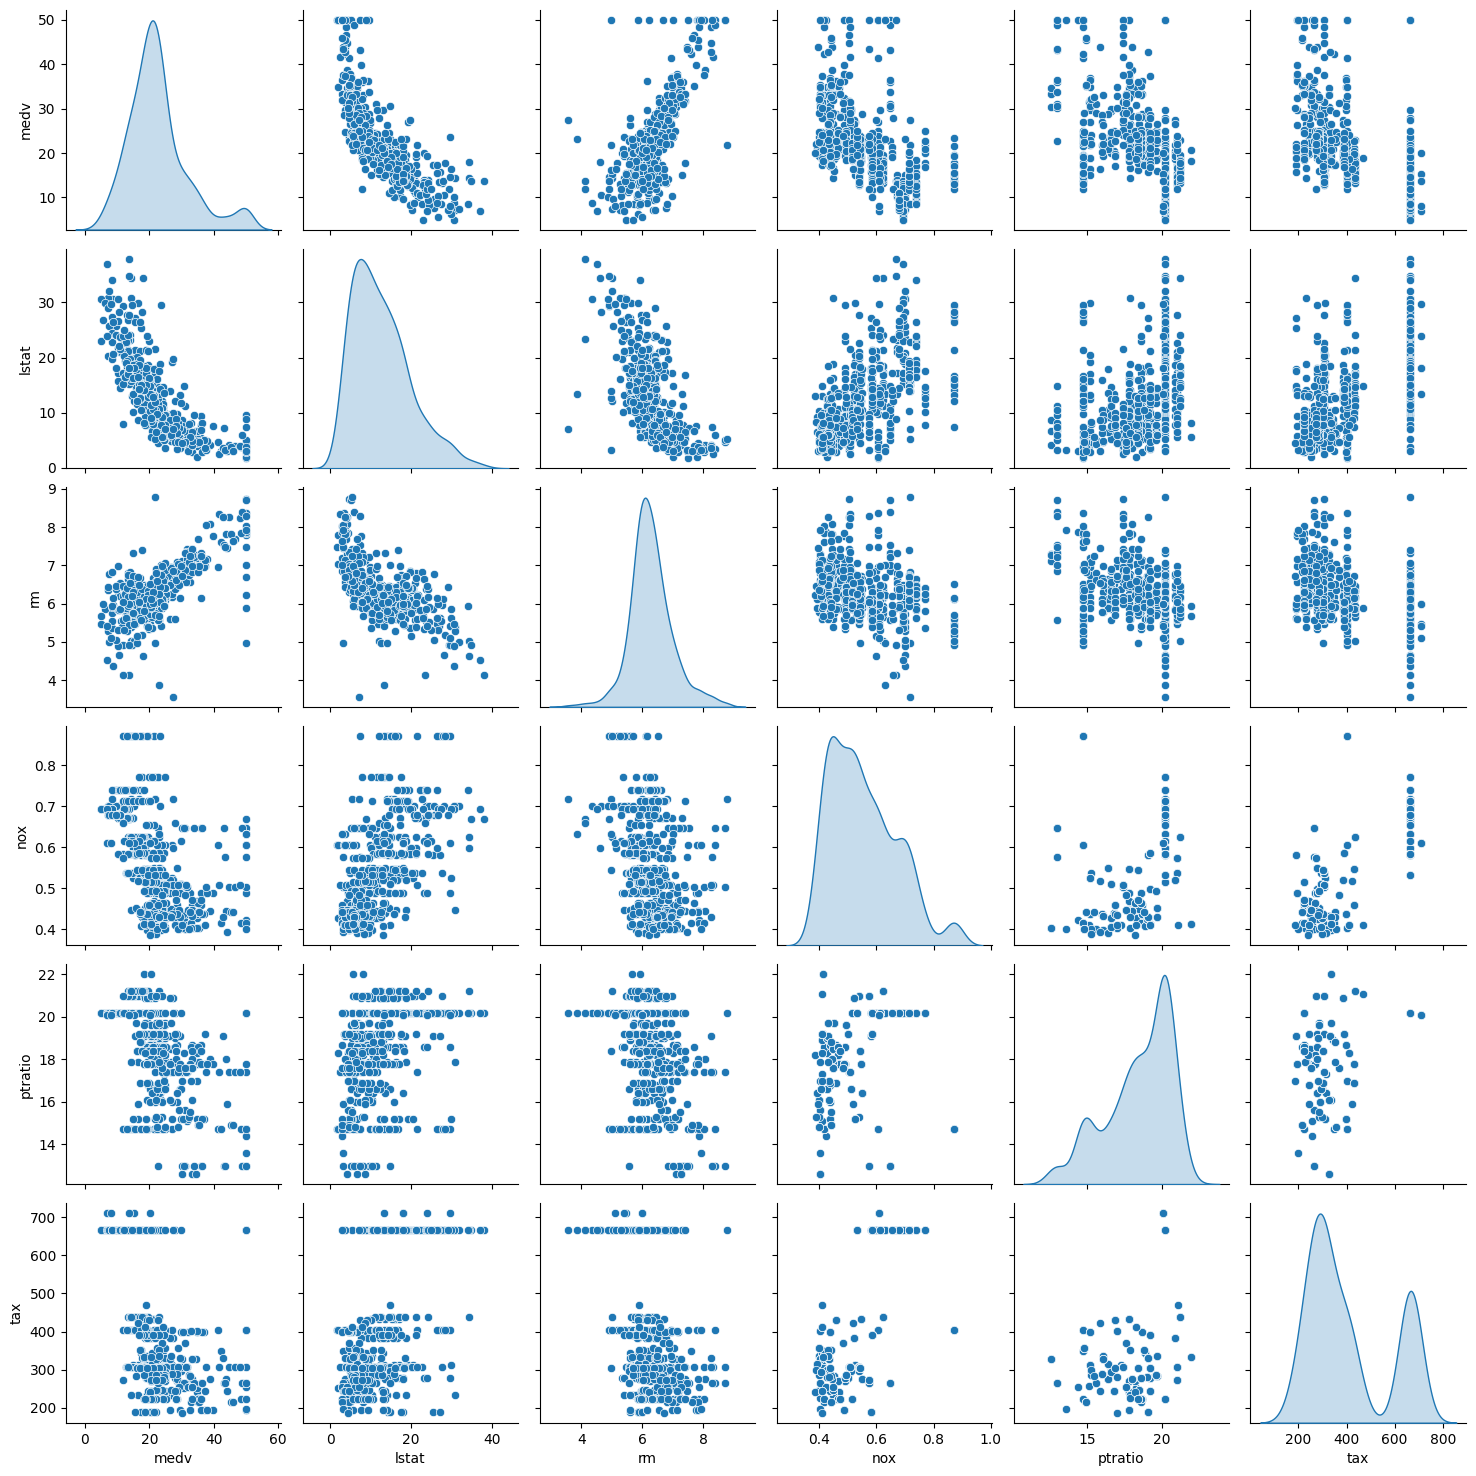

In [46]:
import seaborn as sns
sns.pairplot(datframe[['medv', 'lstat', 'rm', 'nox','ptratio', 'tax']], diag_kind='kde')

In [47]:
datframe.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

In [23]:
# konwersja dataframe do typu tablicowego

dataset = datframe.values

In [ ]:
dataset.shape

In [25]:
# podział zbioru danych na zbirr ze zmiennymi objaśniajacymi [X] i zmienną objasnianą [Y]
X = dataset[:,:-1]
Y = dataset[:,-1]

In [ ]:
Y.shape

In [ ]:
X.shape

In [28]:
# definicja procedury przeznaczonej do budowy i kompilacji modelu sieci neuronowej
def baseline_model():

 model = Sequential()
 # parametr input_sape jest taki sam jak kształt tablicy X
 model.add(Dense(13, input_shape=(13,), kernel_initializer='normal', activation='relu'))
 model.add(Dense(1, kernel_initializer='normal'))

 # kompilacja modelu
 model.compile(loss='mean_squared_error', optimizer='adam')
 return model


**Ewaluacja modelu**
oparatA na walidacji krzyżowej , z podziałem zbioru na 10 podzbiorów

In [30]:
estimator = KerasRegressor(model=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)

In [31]:
results_baseline_model = cross_val_score(estimator, X, Y, cv=kfold, scoring='neg_mean_squared_error')


In [32]:
print("Model podstawowy: %.2f (%.2f) MSE" % (results_baseline_model.mean(), results_baseline_model.std()))

Model podstawowy: -33.84 (24.99) MSE


**Budowa modelu z warstwą standaryzującą dane wejściowe do modelu **

In [33]:
# DEFINICJA PROCEDURY BUDOWY MODELU
def baseline_model():

 model = Sequential()
 model.add(Dense(13, input_shape=(13,), kernel_initializer='normal', activation='relu'))
 model.add(Dense(1, kernel_initializer='normal'))
 # kompilacja  modelu
 model.compile(loss='mean_squared_error', optimizer='adam')
 return model


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [35]:
# budowa pipeline ze standaryzacją danych wejściowych i budową, uczeniem i ewaluacją modelu

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=baseline_model, epochs=50, batch_size=5, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)


In [ ]:
results_baseline_model_with_st = cross_val_score(pipeline, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print("Model podstawowy z warstwą standaryzującą: %.2f (%.2f) MSE" % (results_baseline_model_with_st.mean(), results_baseline_model_with_st.std()))

**Dostrajanie topologii sieci neuronowej**

Model sieci neuronowej można zoptymalizować pod wieloma względami.

Być może punktem największego wpływu jest struktura samej sieci, w tym liczba warstw i liczba neuronów w każdej warstwie.

W tej sekcji zostaną ocenione dwie dodatkowe topologie sieci w celu dalszej poprawy wydajności modelu.

Przyjrzymy się zarówno głębszej, jak i szerszej topologii sieci.



**Ocena głębszej topologii sieci**

Jednym ze sposobów poprawy wydajności sieci neuronowej jest dodanie większej liczby warstw. Może to pozwolić modelowi na wyodrębnienie i ponowne połączenie cech wyższego rzędu osadzonych w danych.

W tej sekcji oceniony zostanie efekt dodania do modelu jeszcze jednej warstwy ukrytej. Jest to tak proste, jak zdefiniowanie nowej funkcji do tworzenia tego głębszego modelu, skopiowanego z powyższego modelu bazowego. Następnie można wstawić nową linię po pierwszej warstwie ukrytej - w tym przypadku z około połową liczby neuronów

In [37]:
# procedura budowy głębszej sieci neuronowej
def larger_model():


 model = Sequential()
 model.add(Dense(13, input_shape=(13,), kernel_initializer='normal', activation='relu'))
 model.add(Dense(6, kernel_initializer='normal', activation='relu'))
 model.add(Dense(1, kernel_initializer='normal'))

 model.compile(loss='mean_squared_error', optimizer='adam')
 return model


In [38]:
# evaluacja  głębszego modelu z warstwą standaryzującą
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)


In [39]:
results_larger_model_with_std = cross_val_score(pipeline, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print("Głębszy model z warstwą standaryzującą : %.2f (%.2f) MSE" % (results_larger_model_with_std.mean(), results_larger_model_with_std.std()))

Głębszy model z warstwą standaryzującą : -24.73 (29.51) MSE


**Ocena szerszej topologii sieci**

Innym podejściem do zwiększenia możliwości reprezentacyjnych modelu jest stworzenie szerszej sieci.

W tej sekcji ocenimy efekt zachowania płytkiej architektury sieci i niemal podwojenia liczby neuronów w jednej warstwie ukrytej.

 W tym przypadku liczba neuronów w warstwie ukrytej zostanie zwiększona z 13 do 20 w porównaniu do modelu bazowego.

In [ ]:

def wider_model():

 model = Sequential()
 model.add(Dense(20, input_shape=(13,), kernel_initializer='normal', activation='relu'))
 model.add(Dense(1, kernel_initializer='normal'))

 model.compile(loss='mean_squared_error', optimizer='adam')
 return model


In [ ]:
# evaluacja szerszego modelu
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=wider_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)


In [ ]:
results = cross_val_score(pipeline, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print("Szerszy model z warstwą standaryzującą: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Wider: -21.54 (23.94) MSE


In [ ]:
print("Model podstawowy                         : %.2f (%.2f) MSE" % (results_baseline_model.mean(), results_baseline_model.std()))
print("Model podstawowy z warstwą standaryzującą: %.2f (%.2f) MSE" % (results_baseline_model_with_st.mean(), results_baseline_model_with_st.std()))
print("Głębszy model z warstwą standaryzującą   : %.2f (%.2f) MSE" % (results_larger_model_with_std.mean(), results_larger_model_with_std.std()))
print("Szerszy model z warstwą standaryzującą   : %.2f (%.2f) MSE" % (results.mean(), results.std()))